In [48]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

In [49]:
file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21


In [50]:
df['time-delta'] = df['datetime'].diff().dt.seconds
for col in ['close']:
    df[f'{col}_diff'] = df[col].pct_change()
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions,time-delta,close_diff
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115,NaN,NaN
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37,300.0,-0.000252
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80,300.0,0.000819
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44,300.0,-0.000629
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21,300.0,0.000609


<AxesSubplot:xlabel='datetime'>

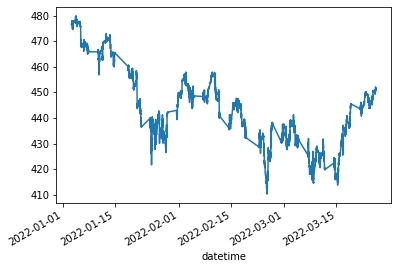

In [51]:
df.set_index('datetime')['close'].plot()

In [108]:
# Window of data we're working with
N = df.shape[0]
print(f'{N} ticks found')

# 2 hour lookback period
LOOKBACK = 2*(60/5)

# Growth requirement
GROWTH_LIMIT = 0.005

# outcome period 30min
HORIZON = 6

X = list()
y = list()
growth = list()

t =1
finish = False
counter = 0
while finish is False:
    
    counter+=1
    print(f'Counter:{counter}',end='\r')
    
    # check we have enough lookback data
    if t<22:
        t+=1
        continue
    
    # check we don't have enough data left then end the cycle
    if (N - t)<5:
        finish = True
        t+=1
        continue
        
    lookback_data = df.loc[t-20:t,['volume','close','open','high','low']].values
    lookback_data = lookback_data/lookback_data[-1]
    outcome_data = df.loc[t+1:t+6,'close_diff'].sum()>GROWTH_LIMIT
    growth_data = df.loc[t+1:t+6,'close_diff'].sum()
    
    X.append(lookback_data)
    y.append(outcome_data)
    growth.append(growth_data)
    
    t+=1

10965 ticks found


In [109]:
y = np.array(y).reshape(-1,1)
y.shape

(10939, 1)

In [111]:
growth = np.array(growth).reshape(-1,1)
growth.shape

(10939, 1)

In [113]:
growth_train = growth[:6000]
growth_test = growth[6000:]

In [110]:
X = np.stack(X)
X.shape

(10939, 21, 5)

In [55]:
X_train = X[:6000]
X_test = X[6000:]

y_train = y[:6000]
y_test = y[6000:]

with open('./data/X_train_2.npy','wb') as f:
    np.save(f,X_train)
    
with open('./data/X_test_2.npy','wb') as f:
    np.save(f,X_test)
    
with open('./data/y_train_2.npy','wb') as f:
    np.save(f,y_train)
    
with open('./data/y_test_2.npy','wb') as f:
    np.save(f,X_test)

# Defining a simple CNN

In [56]:
import tensorflow as tf
from tensorflow import keras

In [57]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [58]:
model = keras.Sequential([
    keras.layers.Conv1D(36,2,
                        activation='sigmoid',
                        input_shape=(X_train.shape[1],X_train.shape[2]),
                        kernel_regularizer=tf.keras.regularizers.l2(l=.05)),
    #keras.layers.Conv1D(3,3,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(2),
    #keras.layers.Conv1D(6,2,activation='relu'),
    #keras.layers.BatchNormalization(),
    #keras.layers.MaxPooling1D(2),    
    keras.layers.Flatten(),
    keras.layers.Dense(10,activation='sigmoid'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [59]:
metrics = [
    tf.metrics.AUC(name='auc')
]

model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

In [60]:
callbacks = [keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)]

In [61]:
history = model.fit(X_train,y_train,batch_size=50,epochs=200,verbose=2,validation_data=(X_test,y_test))

Epoch 1/200
120/120 - 1s - loss: 1.3377 - auc: 0.4896 - val_loss: 1.1114 - val_auc: 0.4928 - 1s/epoch - 10ms/step
Epoch 2/200
120/120 - 0s - loss: 1.0342 - auc: 0.5451 - val_loss: 0.9106 - val_auc: 0.5579 - 293ms/epoch - 2ms/step
Epoch 3/200
120/120 - 0s - loss: 0.8392 - auc: 0.5934 - val_loss: 0.7781 - val_auc: 0.5816 - 303ms/epoch - 3ms/step
Epoch 4/200
120/120 - 0s - loss: 0.7126 - auc: 0.6176 - val_loss: 0.6758 - val_auc: 0.5965 - 282ms/epoch - 2ms/step
Epoch 5/200
120/120 - 0s - loss: 0.6241 - auc: 0.6502 - val_loss: 0.6005 - val_auc: 0.5997 - 272ms/epoch - 2ms/step
Epoch 6/200
120/120 - 0s - loss: 0.5609 - auc: 0.6419 - val_loss: 0.5448 - val_auc: 0.5996 - 264ms/epoch - 2ms/step
Epoch 7/200
120/120 - 0s - loss: 0.5102 - auc: 0.6492 - val_loss: 0.4992 - val_auc: 0.6064 - 276ms/epoch - 2ms/step
Epoch 8/200
120/120 - 0s - loss: 0.4684 - auc: 0.6406 - val_loss: 0.4604 - val_auc: 0.6123 - 295ms/epoch - 2ms/step
Epoch 9/200
120/120 - 0s - loss: 0.4324 - auc: 0.6561 - val_loss: 0.4269 -

Epoch 72/200
120/120 - 0s - loss: 0.1349 - auc: 0.6351 - val_loss: 0.1580 - val_auc: 0.6306 - 288ms/epoch - 2ms/step
Epoch 73/200
120/120 - 0s - loss: 0.1348 - auc: 0.6238 - val_loss: 0.1579 - val_auc: 0.6300 - 277ms/epoch - 2ms/step
Epoch 74/200
120/120 - 0s - loss: 0.1348 - auc: 0.6365 - val_loss: 0.1582 - val_auc: 0.6363 - 278ms/epoch - 2ms/step
Epoch 75/200
120/120 - 0s - loss: 0.1349 - auc: 0.6229 - val_loss: 0.1579 - val_auc: 0.6354 - 274ms/epoch - 2ms/step
Epoch 76/200
120/120 - 0s - loss: 0.1350 - auc: 0.6192 - val_loss: 0.1579 - val_auc: 0.6353 - 266ms/epoch - 2ms/step
Epoch 77/200
120/120 - 0s - loss: 0.1347 - auc: 0.6202 - val_loss: 0.1583 - val_auc: 0.6452 - 298ms/epoch - 2ms/step
Epoch 78/200
120/120 - 0s - loss: 0.1345 - auc: 0.6311 - val_loss: 0.1579 - val_auc: 0.6360 - 308ms/epoch - 3ms/step
Epoch 79/200
120/120 - 0s - loss: 0.1341 - auc: 0.6338 - val_loss: 0.1582 - val_auc: 0.6442 - 292ms/epoch - 2ms/step
Epoch 80/200
120/120 - 0s - loss: 0.1346 - auc: 0.6157 - val_los

Epoch 142/200
120/120 - 0s - loss: 0.1322 - auc: 0.6536 - val_loss: 0.1563 - val_auc: 0.6567 - 272ms/epoch - 2ms/step
Epoch 143/200
120/120 - 0s - loss: 0.1323 - auc: 0.6570 - val_loss: 0.1557 - val_auc: 0.6605 - 277ms/epoch - 2ms/step
Epoch 144/200
120/120 - 0s - loss: 0.1322 - auc: 0.6572 - val_loss: 0.1566 - val_auc: 0.6639 - 281ms/epoch - 2ms/step
Epoch 145/200
120/120 - 0s - loss: 0.1316 - auc: 0.6705 - val_loss: 0.1563 - val_auc: 0.6583 - 273ms/epoch - 2ms/step
Epoch 146/200
120/120 - 0s - loss: 0.1321 - auc: 0.6593 - val_loss: 0.1562 - val_auc: 0.6571 - 272ms/epoch - 2ms/step
Epoch 147/200
120/120 - 0s - loss: 0.1316 - auc: 0.6692 - val_loss: 0.1560 - val_auc: 0.6604 - 275ms/epoch - 2ms/step
Epoch 148/200
120/120 - 0s - loss: 0.1325 - auc: 0.6409 - val_loss: 0.1550 - val_auc: 0.6588 - 277ms/epoch - 2ms/step
Epoch 149/200
120/120 - 0s - loss: 0.1321 - auc: 0.6573 - val_loss: 0.1558 - val_auc: 0.6647 - 274ms/epoch - 2ms/step
Epoch 150/200
120/120 - 0s - loss: 0.1316 - auc: 0.6661 

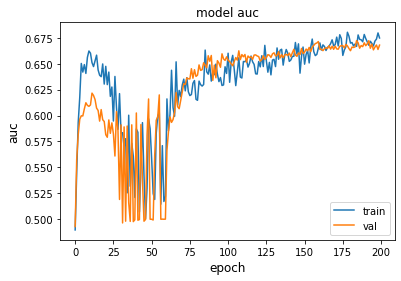

In [62]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

In [63]:
model.predict(X_test)

155/155 [==============================] - 0s 840us/step


array([[0.0322422 ],
       [0.02816149],
       [0.03252784],
       ...,
       [0.05614639],
       [0.05372984],
       [0.05350006]], dtype=float32)

In [64]:
from sklearn.metrics import roc_auc_score

2*roc_auc_score(y_test,model.predict(X_test))-1

155/155 [==============================] - 0s 878us/step


0.33999931778644443

Tops out at 0.35....

# Analyzing model performance

In [65]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
fpr_train, tpr_train, _ = roc_curve(y_train, model.predict(X_train))

188/188 [==============================] - 0s 800us/step


188/188 [==============================] - 0s 790us/step


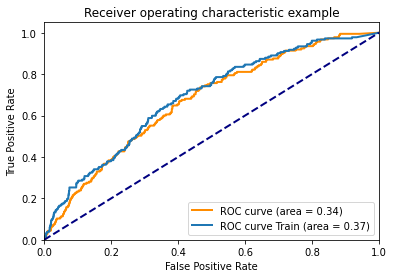

In [66]:
plt.figure()
lw = 2
roc = 2*roc_auc_score(y_test,model.predict(X_test))-1
roc_train = 2*roc_auc_score(y_train,model.predict(X_train))-1

plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc,
)

plt.plot(
    fpr_train,
    tpr_train,
    #color="darkorange",
    lw=lw,
    label="ROC curve Train (area = %0.2f)" % roc_train,
)


plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

155/155 [==============================] - 0s 824us/step


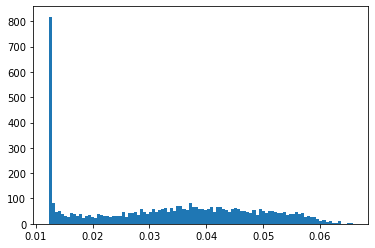

In [67]:
plt.hist(model.predict(X_test),bins=100)
plt.show()

In [68]:
test_pred = model.predict(X_test).ravel()
test_pred

155/155 [==============================] - 0s 878us/step


array([0.0322422 , 0.02816149, 0.03252784, ..., 0.05614639, 0.05372984,
       0.05350006], dtype=float32)

<AxesSubplot:xlabel='datetime'>

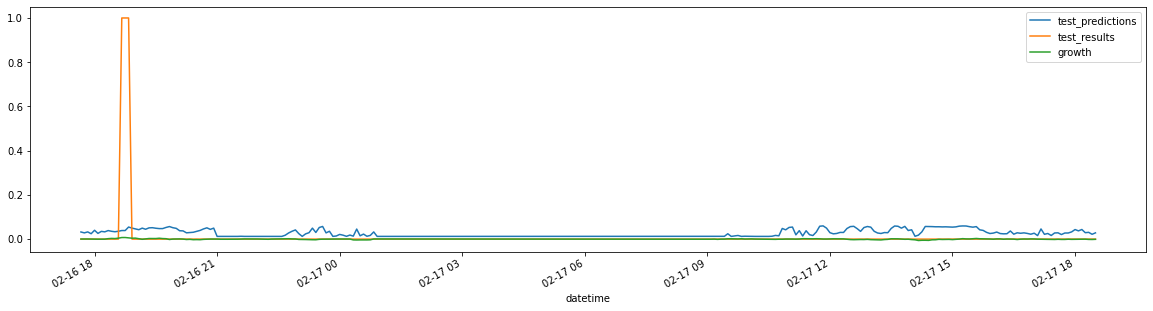

In [116]:
test_pred_df = pd.DataFrame({'test_predictions':test_pred,'test_results':y_test.ravel(),'growth':growth_test.ravel()})
test_datetime_df = df[['datetime']][6020:-6].reset_index(drop=True)
results_df = pd.concat([test_datetime_df,test_pred_df],axis=1).set_index('datetime')
results_df[:200].plot(figsize=[20,5])

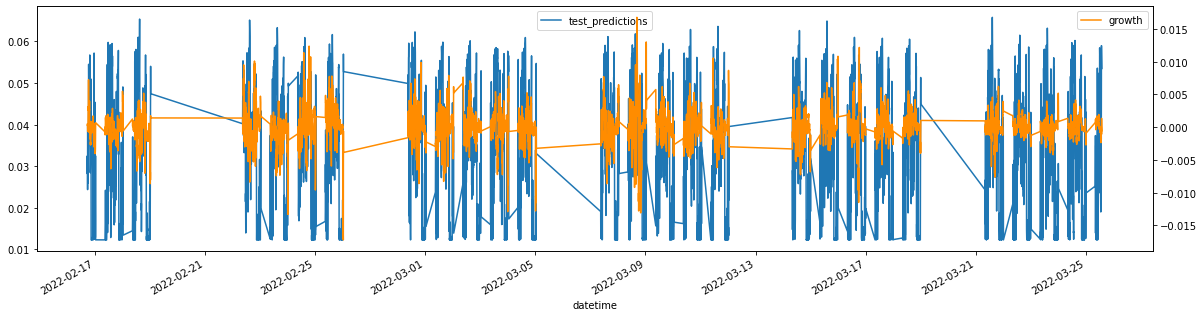

In [122]:
axes = results_df[['test_predictions']].plot(figsize=[20,5])
axes2 = axes.twinx()
results_df[['growth']].plot(ax=axes2,c='darkorange')
#plt.yscale('log')
plt.show()

In [124]:
results_df['test_predictions_bin'] = pd.qcut(results_df['test_predictions'],10)
results_df.groupby('test_predictions_bin')['test_results'].agg(['count','sum','mean'])

,count,sum,mean
test_predictions_bin,,,
"(0.012256000000000001, 0.012272]",494,1.0,0.002024
"(0.012272, 0.014337]",494,11.0,0.022267
"(0.014337, 0.022349]",494,11.0,0.022267
"(0.022349, 0.029372]",494,12.0,0.024291
"(0.029372, 0.034445]",494,11.0,0.022267
"(0.034445, 0.038403]",493,19.0,0.038540
"(0.038403, 0.042899]",494,25.0,0.050607
"(0.042899, 0.047827]",494,24.0,0.048583
"(0.047827, 0.0534]",494,29.0,0.058704


###### running a simulation

In [150]:
results_df.test_predictions>0.01

datetime
2022-02-16 17:40:00    True
2022-02-16 17:45:00    True
2022-02-16 17:50:00    True
2022-02-16 17:55:00    True
2022-02-16 18:00:00    True
                       ... 
2022-03-25 13:20:00    True
2022-03-25 13:25:00    True
2022-03-25 13:30:00    True
2022-03-25 13:35:00    True
2022-03-25 13:40:00    True
Name: test_predictions, Length: 4939, dtype: bool

In [155]:
np.arange(0.0,0.7,0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69])

In [172]:
results_df[results_df.test_predictions>0.0].growth.sum()

0.1292404931238622

<AxesSubplot:xlabel='datetime'>

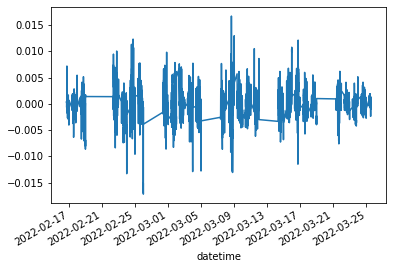

In [166]:
results_df.growth.plot()

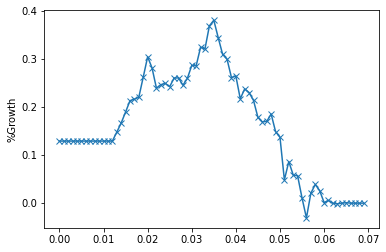

In [162]:
profit = list()
cutoff = list()
for i in np.arange(0.0,0.07,0.001):
    p = results_df[results_df.test_predictions>i].growth.sum()
    profit.append(p)
    cutoff.append(i)
plt.plot(cutoff,profit,marker='x')
plt.ylabel('%Growth')
plt.show()

In [164]:
results_df[results_df.test_predictions>0.001].growth.sum()

0.1292404931238622

If you were to just buy when the model has a prob greater than 0.04 you would get a 5% return, which over 36 days ain't bad.

Of course, this 10% figure will be reduced, and could even be eradicated by fees and spread in the buy sell.

In [147]:
10000*1.05**(15*12)

65173918.409652695

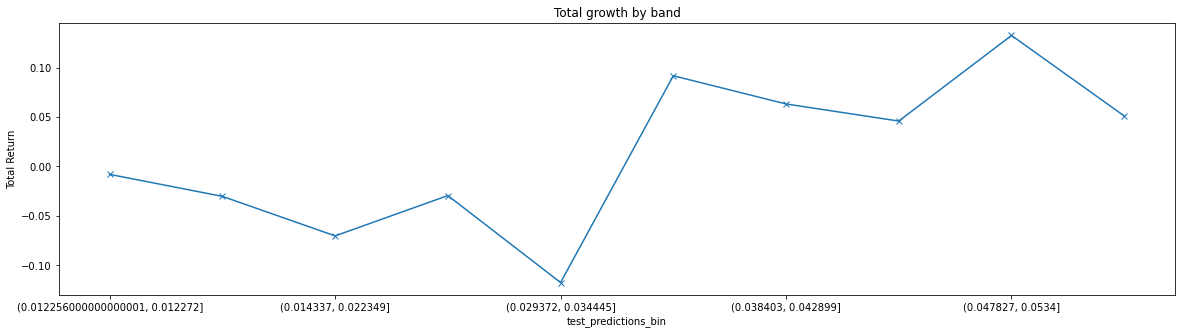

In [138]:
results_df.groupby('test_predictions_bin')['growth'].agg(['count','sum','mean'])['sum'].plot(figsize=[20,5],marker='x')
plt.ylabel('Total Return')
plt.title('Total growth by band')
plt.show()

In [135]:
results_df['test_predictions_bin'] = pd.qcut(results_df['test_predictions'],10)
results_df.groupby('test_predictions_bin')['growth'].agg(['count','sum','mean'])

,count,sum,mean
test_predictions_bin,,,
"(0.012256000000000001, 0.012272]",494,-0.007985,-0.000016
"(0.012272, 0.014337]",494,-0.030208,-0.000061
"(0.014337, 0.022349]",494,-0.070167,-0.000142
"(0.022349, 0.029372]",494,-0.029410,-0.000060
"(0.029372, 0.034445]",494,-0.117300,-0.000237
"(0.034445, 0.038403]",493,0.091700,0.000186
"(0.038403, 0.042899]",494,0.063190,0.000128
"(0.042899, 0.047827]",494,0.045912,0.000093
"(0.047827, 0.0534]",494,0.132443,0.000268


In [136]:
results_df.index.max()-results_df.index.min()

Timedelta('36 days 20:00:00')

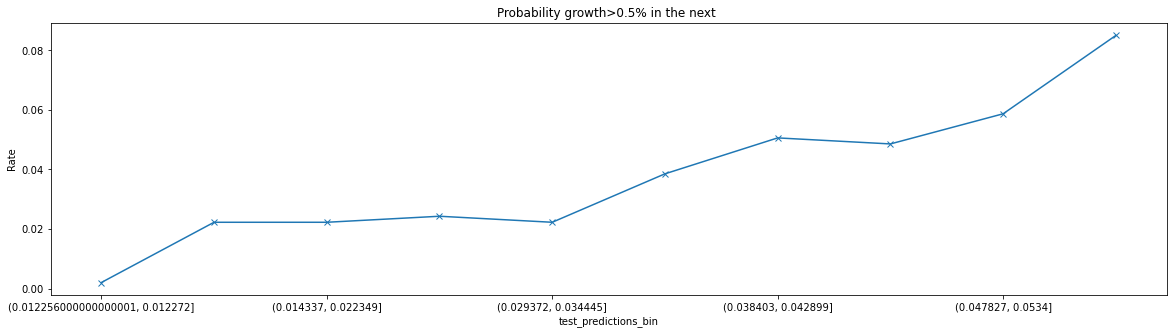

In [137]:
results_df.groupby('test_predictions_bin')['test_results'].agg(['count','sum','mean'])['mean'].plot(figsize=[20,5],marker='x')
plt.ylabel('Rate')
plt.title('Probability growth>0.5% in the next ')
plt.show()

In [106]:
0.005

0.005

Additional features?
- time since opening?
- interday movements

In [ ]:
growth_test